In [2]:
import os, sys
sys.path.append(os.path.abspath("../src"))

import numpy as np
import scipy as sp
import qutip
import time as timer
import matplotlib.pyplot as plt

import optimization, simulation, utils, visualization

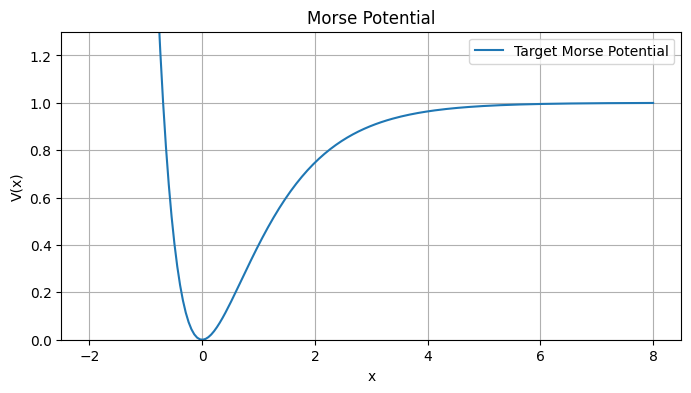

In [4]:
morse_potential = utils.MorsePotential(
    de = 1.0,
    b = 1.0,
    x0 = 0.0
)

morse_potential.plot_potential()

In [5]:
backend = utils.Gates(dim = 75)

time = 1.0

depth = 14

morse_hamiltonian = backend.m_ham_full(morse_potential)
expanded_morse_hamiltonain = backend.m_ham_expansion_full(morse_potential, 4)

In [6]:
init_qubit_state = qutip.basis(2,0)
init_qumode_state = qutip.coherent(backend.dim, 1.0)
full_init_state = qutip.tensor(init_qubit_state, init_qumode_state)

In [ ]:
# Determining the best dimension to use for testing
# Extra Information:
#   Only the qumode space is being looked at

# 1. choose the initial state to evolve and create it in the high dimension
high_dim = 80
high_init_qum_state = qutip.coherent(high_dim, 1.0)

# 2. create the position, momentum, and hamiltonian matrices for a high dimension
high_backend = utils.Gates(dim = high_dim)
high_x = qutip.Qobj(high_backend.x_op)
high_p = qutip.Qobj(high_backend.p_op)
high_ham = qutip.Qobj(high_backend.m_ham(morse_potential))

# 3. evolve the initial state in a high dimension at different times
times = np.linspace(0, 5, 200)
high_states = []
for t in times:
    evo_matrix_at_t = qutip.Qobj(high_backend.m_evo(morse_potential, t))
    high_states.append(evo_matrix_at_t * high_init_qum_state)

# 4. calculate the expectation value of position, momentum, and hamiltonian operators from the evolved state at different times
x_exp = np.real(np.array(qutip.expect(high_x, high_states)))
p_exp = np.real(np.array(qutip.expect(high_p, high_states)))
h_exp = np.real(np.array(qutip.expect(high_ham, high_states)))
h_avg = np.average(h_exp)

# 5. repeat steps 1-4 for lower dimensions
test_dims = [75] # to be changed for different dimensions we want to test
test_p_exps = []
test_x_exps = []
test_h_exps = []
test_h_avgs = []

for test_dim in test_dims:
    test_init_qum_state = qutip.coherent(test_dim, 1.0)

    dim_backend = utils.Gates(dim = test_dim)
    test_x = qutip.Qobj(dim_backend.x_op)
    test_p = qutip.Qobj(dim_backend.p_op)
    test_ham = qutip.Qobj(dim_backend.m_ham(morse_potential))

    test_states = []

    for t in times:
        test_evo_matrix_at_t = qutip.Qobj(dim_backend.m_evo(morse_potential, t))
        test_states.append(test_evo_matrix_at_t * test_init_qum_state)

    test_x_exp = np.real(np.array(qutip.expect(test_x, test_states)))
    test_p_exp = np.real(np.array(qutip.expect(test_p, test_states)))
    test_h_exp = np.real(np.array(qutip.expect(test_ham, test_states)))
    test_h_avg = np.average(test_h_exp)

    test_x_exps.append(test_x_exp)
    test_p_exps.append(test_p_exp)
    test_h_exps.append(test_h_exp)
    test_h_avgs.append(test_h_avg)

p_exp[0] = 1e-12
for k in range(len(test_p_exps)):
    test_p_exps[k][0] = 1e-12

# 6. compare the difference over the times (relative percent differences)
x_percent_diffs = []
p_percent_diffs = []
h_percent_diffs = []
h_avg_percent_diffs = []

for i in range(len(test_h_avgs)):
    percent_diff_x = 100 * np.abs(x_exp - test_x_exps[i]) / np.abs((x_exp + test_x_exps[i]) / 2)
    
    percent_diff_p = 100 * np.abs(p_exp - test_p_exps[i]) / np.abs((p_exp + test_p_exps[i]) / 2)

    percent_diff_h = 100 * np.abs(h_exp - test_h_exps[i]) / np.abs((h_exp + test_h_exps[i]) / 2)
    
    percent_diff_avg_h = 100 * np.abs(h_avg - test_h_avgs[i]) / np.abs((h_avg + test_h_avgs[i]) / 2)
    
    x_percent_diffs.append(percent_diff_x)
    p_percent_diffs.append(percent_diff_p)
    h_percent_diffs.append(percent_diff_h)
    h_avg_percent_diffs.append(percent_diff_avg_h)

# 7. plot
x_diff = x_percent_diffs[0]
p_diff = p_percent_diffs[0]
h_diff = h_percent_diffs[0]

plt.figure(figsize=(10, 6))
plt.plot(times, x_diff, label='Position % diff', color='blue')
plt.plot(times, p_diff, label='Momentum % diff', color='orange')
plt.plot(times, h_diff, label='Hamiltonian (Energy) % diff', color='green')

plt.xlabel('Time')
plt.ylabel('Percent Difference (%)')
plt.title(f'Relative Percent Differences: High Dim {high_dim} vs Low Dim {test_dims[0]}')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

In [ ]:
high_state_1 = qutip.basis(2,0)
high_state_2 = qutip.coherent(high_backend.dim, 1.0)
high_init_state = qutip.tensor(high_state_1, high_state_2)
high_full_morse = high_backend.m_ham_full(morse_potential)


high_dim_results = simulation.simulate(
    init_state=high_init_state,
    full_hamiltonian=high_full_morse,
    end_time=5.0,
    backend=high_backend
)

visualization.plot_wigner_fucntion(high_dim_results, 1, 6)

In [ ]:
true_results = simulation.simulate(
    init_state = full_init_state,
    full_hamiltonian = morse_hamiltonian,
    end_time = 3.0,
    backend = backend
)

visualization.plot_wigner_fucntion(true_results, 1, 6)

In [ ]:
expansion_results = simulation.simulate(
    init_state = full_init_state,
    full_hamiltonian = expanded_morse_hamiltonain,
    end_time = 1.0,
    backend = backend
)

visualization.plot_wigner_fucntion(expansion_results, 1, 6)

In [16]:
def sequence_function(init_params, init_state, depth, times):
    
    states = []

    for n in range(0, len(times)):

        U_total = np.kron(backend.I_q, backend.I_o)

        for layer in range(0, depth):

            chi = init_params[0]
            alpha_real = init_params[1+4*layer]
            alpha_imag = init_params[2+4*layer]
            theta = init_params[3+4*layer]
            phi = init_params[4+4*layer]

            conr = backend.c_r(omega = 0.0, chi = chi, t = times[n] / depth)
            disp = backend.cv_d_full(alpha_real + 1j*alpha_imag)
            qrot = backend.q_xy_r_full(theta, phi)

            U_layer = disp @ qrot @ conr
            U_total = U_layer @ U_total

        U_total = qutip.Qobj(U_total, dims = [[2, backend.dim], [2, backend.dim]])
        state_for_time = U_total * init_state
        states.append(state_for_time)

    result = {}
    result['states'] = states
    result['times'] = times

    return result

def cost_function(params, depth, init_state, times, target_results):

    global best_params, best_cost, curr_iter

    init_params = []

    chi = params[0]
    alpha_reals = params[1::4]
    alpha_imags = params[2::4]
    thetas = params[3::4]
    phis = params[4::4]

    init_params = [chi] + init_params

    for i in range(depth):
        init_params = init_params + [alpha_reals[i], alpha_imags[i], thetas[i], phis[i]]

    result = sequence_function(init_params, init_state, depth, times)

    fidelities = []

    for i in range(len(times)):
        synth_result = result['states'][i]
        target_result = target_results[i]
        fidelities.append(qutip.fidelity(synth_result, target_result))
    
    cost = 100 * (1 - np.sum(fidelities) / len(fidelities))
    curr_iter += 1 
    if ((curr_iter % 1000) == 0):
        print(f"Current cost: {cost:.6f}; Iteration: {curr_iter}")

    if cost < best_cost:
        best_cost = cost
        best_params = params.copy()
        #print(f"New best cost: {best_cost:.6f} with params: {best_params}")

    return cost

best_cost = np.inf
best_params = None
times = np.linspace(0.5, 2.75, 10)
#target_results = [ (qutip.Qobj(backend.m_evo_expansion_full(morse_potential, 4, t), dims = [[2, backend.dim], [2, backend.dim]]) * full_init_state) for t in times]
target_results = [ (qutip.Qobj(backend.m_evo_full(morse_potential, t), dims = [[2, backend.dim], [2, backend.dim]]) * full_init_state) for t in times]
start_params = [0.5] * (1 + 4 * depth)

print(times)
print(start_params)

[0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


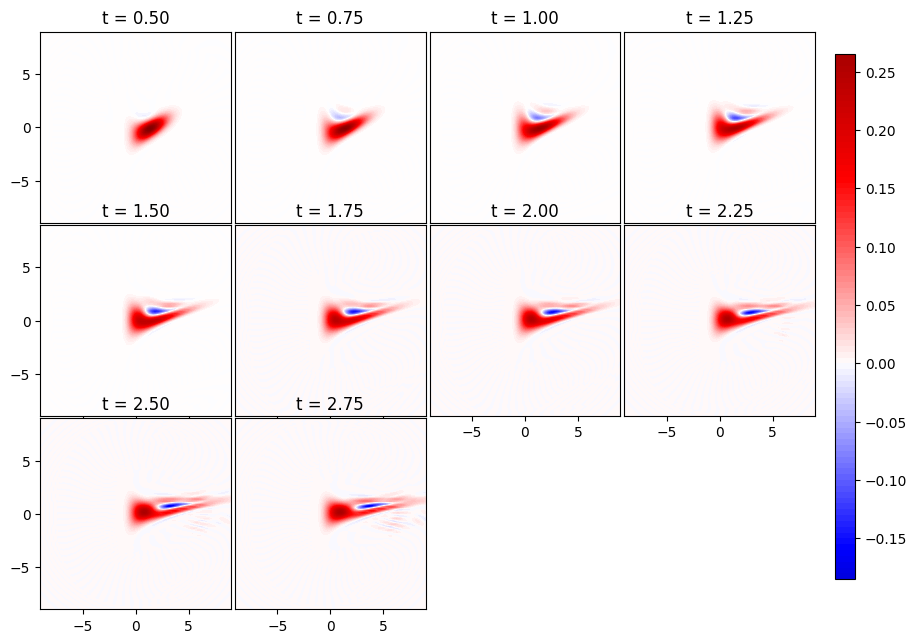

In [17]:
test_results = {}
test_results['states'] = target_results
test_results['times'] = times
visualization.plot_wigner_fucntion(test_results, 1, 10)

In [33]:
# Brute Force Optimization
curr_iter = 0

stop_threshold = 0.1

class EarlyStop(Exception):
    pass

def callback(xk):
    if best_cost < stop_threshold:
        raise EarlyStop()
    
try:
    theresult = sp.optimize.minimize(
        cost_function,
        start_params,
        args=(depth, full_init_state, times, target_results),
        method='BFGS',
        callback=callback,
        options={'disp': True, 'maxiter': 10000}
    )
except EarlyStop:
    print("<0.1 cost reached")

Current cost: 94.602556; Iteration: 1000
Current cost: 85.719097; Iteration: 2000
Current cost: 39.195905; Iteration: 3000
Current cost: 16.562440; Iteration: 4000
Current cost: 8.734657; Iteration: 5000
Current cost: 6.063094; Iteration: 6000
Current cost: 4.903934; Iteration: 7000
Current cost: 4.631375; Iteration: 8000
Current cost: 4.354636; Iteration: 9000
Current cost: 3.794217; Iteration: 10000
Current cost: 3.323327; Iteration: 11000
Current cost: 2.617917; Iteration: 12000
Current cost: 2.143834; Iteration: 13000
Current cost: 1.912914; Iteration: 14000
Current cost: 1.870802; Iteration: 15000
Current cost: 1.821335; Iteration: 16000
Current cost: 1.778389; Iteration: 17000
Current cost: 1.692523; Iteration: 18000
Current cost: 3.114686; Iteration: 19000
Current cost: 1.418558; Iteration: 20000
Current cost: 1.398896; Iteration: 21000
Current cost: 1.393365; Iteration: 22000
Current cost: 1.392216; Iteration: 23000
Current cost: 1.391996; Iteration: 24000
Current cost: 1.39180

c:\Users\alexa\QuantumComputingPrograms\env\Lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [18]:
# Parameter Propogation Optimization
curr_iter = 0
stop_threshold = 0.11
best_params = start_params
param_history = []
class EarlyStop(Exception):
    pass

def callback(xk):
    if best_cost < stop_threshold:
        raise EarlyStop()
    
for i, target in enumerate(target_results):
    print(f"Optimizing time {times[i]}")
    best_cost = np.inf
    try:
        theresult = sp.optimize.minimize(
            cost_function,
            best_params,
            args=(depth, full_init_state, [times[i]], [target]),
            method='BFGS',
            callback=callback,
            options={'disp': True, 'maxiter': 10000}
        )
    except EarlyStop:
        print("<0.11 cost reached")
    
    param_history.append(best_params.copy())


Optimizing time 0.5
Current cost: 99.994920; Iteration: 1000
Current cost: 99.991146; Iteration: 2000
Current cost: 76.302469; Iteration: 3000
Current cost: 71.762898; Iteration: 4000
Current cost: 58.519675; Iteration: 5000
Current cost: 31.103540; Iteration: 6000
Current cost: 1.681919; Iteration: 7000
Current cost: 0.178132; Iteration: 8000
<0.11 cost reached
Optimizing time 0.75
Current cost: 3.979229; Iteration: 9000
Current cost: 0.594898; Iteration: 10000
Current cost: 0.229098; Iteration: 11000
<0.11 cost reached
Optimizing time 1.0
Current cost: 95.574533; Iteration: 12000
Current cost: 1.196372; Iteration: 13000
Current cost: 0.380438; Iteration: 14000
Current cost: 0.174607; Iteration: 15000
<0.11 cost reached
Optimizing time 1.25
Current cost: 31.235386; Iteration: 16000
Current cost: 0.626522; Iteration: 17000
Current cost: 0.176061; Iteration: 18000
Current cost: 0.136222; Iteration: 19000
<0.11 cost reached
Optimizing time 1.5
Current cost: 13.407496; Iteration: 20000
Cu

c:\Users\alexa\QuantumComputingPrograms\env\Lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.153978
         Iterations: 451
         Function evaluations: 29708
         Gradient evaluations: 512
Optimizing time 2.75
Current cost: 1.255814; Iteration: 136000
Current cost: 0.359746; Iteration: 137000
Current cost: 0.264613; Iteration: 138000
Current cost: 0.244258; Iteration: 139000
Current cost: 0.235470; Iteration: 140000
Current cost: 0.220280; Iteration: 141000
Current cost: 0.208160; Iteration: 142000
Current cost: 0.205559; Iteration: 143000
Current cost: 0.192212; Iteration: 144000
Current cost: 0.177489; Iteration: 145000
Current cost: 0.166250; Iteration: 146000
Current cost: 0.160930; Iteration: 147000
Current cost: 0.158260; Iteration: 148000
Current cost: 0.157266; Iteration: 149000
Current cost: 0.156297; Iteration: 150000
Current cost: 0.155549; Iteration: 151000
Current cost: 0.154803; Iteration: 152000
Current cost: 0.154649; Iteration: 153000
Current cost: 0.154127; Iteration: 154000
Current cost: 0.153971; Iteration: 155000


c:\Users\alexa\QuantumComputingPrograms\env\Lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
print(best_params)

In [36]:
print(cost_function(best_params, depth, full_init_state, times, target_results))

0.9262925590629689


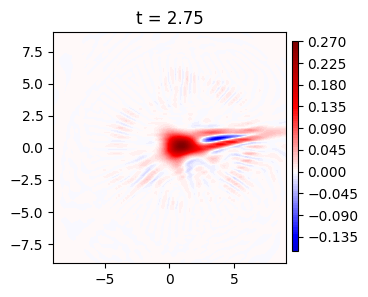

In [37]:
results_to_viz = sequence_function(best_params, full_init_state, depth, times)
visualization.plot_wigner_fucntion(results_to_viz, 1, 1)

In [19]:
viz_times = [2.75]
print(cost_function(best_params, depth, full_init_state, viz_times, [target_results[9]]))

0.15074459289130537


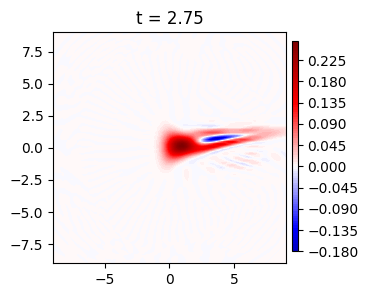

In [20]:
viz_times = [2.75]

viz_best_params = sequence_function(best_params, full_init_state, depth, viz_times)
visualization.plot_wigner_fucntion(viz_best_params, 1, 1)

In [ ]:
# Real test for best method
# Infidelities data (gate depth 5, 6, 7, 8, 9):
# SLSQP: [0.5130, 4.9747, 1.8633, 19.1999, 0.0664]
# BFGS: [1.5443, 0.2487, 0.1621, 0.0310, 0.0236]
# trust-constr: [1.0865, 0.8450, 0.1949, 0.0885, 0.1812]
# COBYLA: [12.2071, 3.2977, 11.7109, 3.2171, 0.8535]
# Nelder-Mead: [3.5719, 3.0565, 2.7259, 0.8683, 0.7954]
# Powell: [0.6675, 1.1726, 0.3950, 0.4555, 0.5423]
# L-BFGS-B: [1.0865, 0.2355, 0.7577, 0.2712, 0.2162]
# TNC: [6.8459, 5.7633, 30.8886, 17.2874, 7.3921]
# COBYQA: [12.2069, 0.5927, 0.2945, 0.8251, 0.2922]

# Gate depths
depths = np.array([5, 6, 7, 8, 9])

# Infidelities data
data = {
    "SLSQP": [0.5130, 4.9747, 1.8633, 19.1999, 0.0664],
    "BFGS": [1.5443, 0.2487, 0.1621, 0.0310, 0.0236],
    "trust-constr": [1.0865, 0.8450, 0.1949, 0.0885, 0.1812],
    "COBYLA": [12.2071, 3.2977, 11.7109, 3.2171, 0.8535],
    "Nelder-Mead": [3.5719, 3.0565, 2.7259, 0.8683, 0.7954],
    "Powell": [0.6675, 1.1726, 0.3950, 0.4555, 0.5423],
    "L-BFGS-B": [1.0865, 0.2355, 0.7577, 0.2712, 0.2162],
    "TNC": [6.8459, 5.7633, 30.8886, 17.2874, 7.3921],
    "COBYQA": [12.2069, 0.5927, 0.2945, 0.8251, 0.2922],
}

# Plot setup
plt.figure(figsize=(10, 6))
for method, values in data.items():
    plt.plot(depths, values, marker='o', label=method)

plt.title("Infidelities vs Gate Depth for Optimization Methods")
plt.xlabel("Gate Depth")
plt.ylabel("Infidelity")
plt.yscale("log")  # Optional: helps visualize wide variations
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.legend()
plt.tight_layout()
plt.xticks(depths)

In [ ]:
# Test the different optimizaiton methods
# Gate Depth: 7, Optimizing for Expansion order 4, time = 1.0
# Time to reach under 1.3 infidelity (in seconds) (tiem limit 120s)
# COBYLA: time limit reached
# BFGS: 15.97, 15.74, 20.18, 16.41, 16.31
# Nelder-Mead: time limit reached
# Powell: time limit reached
# CG: time limit reached
# L-BFGS-B: fidelity not reached
# TNC: fidelity not reached
# COBYQA: time limit reached
# SLSQP: 13.77, 14.22, 14.48, 13.71, 14.56
# trust-constr: time limit reached
curr_iter = 0

target_cost = 1.3
time_limit = 120

start_time = timer.time()

def fidelity_limited_callback(xk, *args):
    global best_cost, best_params

    curr_cost = cost_function(xk, depth, full_init_state, times, target_results)
    elapsed = timer.time() - start_time

    # Track progress
    if curr_cost < best_cost:
        best_cost = curr_cost
        best_params = xk.copy()
        print(f"⏱️ {elapsed:.2f}s | Best cost so far: {best_cost:.6f}")

    # --- Stop conditions ---
    if curr_cost <= target_cost:
        print(f"🎯 Target fidelity reached in {elapsed:.2f} seconds.")
        raise KeyboardInterrupt  # Graceful stop

    if elapsed >= time_limit:
        print(f"⏰ Time limit of {time_limit/60:.1f} minutes reached.")
        raise KeyboardInterrupt  # Graceful stop

try:
    theresult = sp.optimize.minimize(
        cost_function,
        start_params,
        args=(depth, full_init_state, times, target_results),
        method='trust-constr',
        options={'maxiter': 100000},
        callback=fidelity_limited_callback
    )
except KeyboardInterrupt:
    elapsed = timer.time() - start_time
    print(f"⏱️ Total time: {elapsed:.2f} seconds.")

In [ ]:
# Data (seconds to reach target fidelity)
data = {
    "COBYLA": None,  # time limit reached
    "BFGS": [15.97, 15.74, 20.18, 16.41, 16.31],
    "Nelder-Mead": None,
    "Powell": None,
    "CG": None,
    "L-BFGS-B": None,
    "TNC": None,
    "COBYQA": None,
    "SLSQP": [13.77, 14.22, 14.48, 13.71, 14.56],
    "trust-constr": None
}

optimizers = []
avg_times = []
timeouts = []

for name, times in data.items():
    if not times:
        avg_times.append(None)
        timeouts.append(True)
    else:
        avg_times.append(np.mean(times))
        timeouts.append(False)
    optimizers.append(name)

plt.figure(figsize=(10, 5))

# Bars for those that completed
for i, (opt, avg, timeout) in enumerate(zip(optimizers, avg_times, timeouts)):
    if timeout:
        plt.bar(opt, 120, color="lightgray", hatch="//", label="Time limit" if i == 0 else "")
    else:
        plt.bar(opt, avg, color="skyblue", label="Completed" if i == 0 else "")
        # Add text label above the bar
        plt.text(opt, avg + 2, f"{avg:.2f}s", ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.ylabel("Time to reach target fidelity (s)")
plt.title("Optimizer Performance Comparison")
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 130)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
inits_to_viz = sequence_function(start_params, full_init_state, depth, times)
visualization.plot_wigner_fucntion(inits_to_viz, 1, 1)

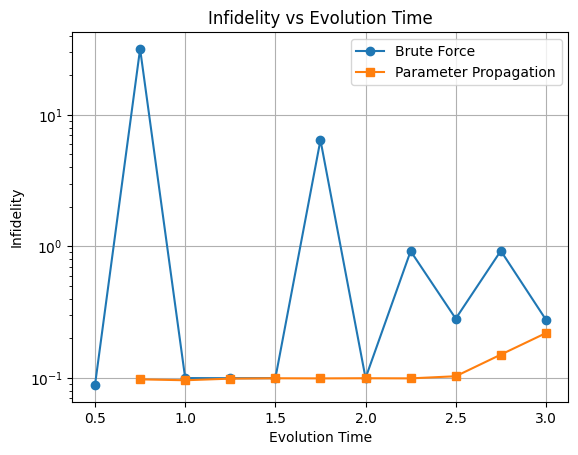

In [3]:
# Data
t = np.array([0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0])

inf_brute = np.array([
    0.088697, 31.673326, 0.099968, 0.099769, 0.099833,
    6.434862, 0.099994, 0.921632, 0.282859, 0.926293, 0.277854
])

inf_prop = np.array([
    np.nan, 0.097800, 0.096235, 0.099003, 0.099651,
    0.099434, 0.099695, 0.099450, 0.103233, 0.150745, 0.219672
])

# Plot
plt.figure()
plt.plot(t, inf_brute, marker='o', label='Brute Force')
plt.plot(t, inf_prop, marker='s', label='Parameter Propagation')
plt.yscale('log')  # makes failures obvious
plt.xlabel("Evolution Time")
plt.ylabel("Infidelity")
plt.title("Infidelity vs Evolution Time")
plt.legend()
plt.grid(True)
plt.show()


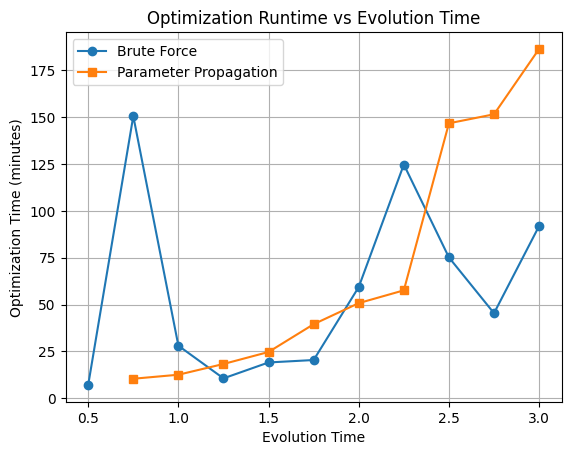

In [4]:
# Runtime data (minutes)
time_brute = np.array([
    7.10, 150.57, 28.03, 10.60, 19.09,
    20.39, 59.35, 124.73, 75.15, 45.38, 91.91
])

time_prop = np.array([
    np.nan, 10.40, 12.54, 18.27, 24.68,
    39.51, 50.76, 57.58, 146.74, 151.54, 186.43
])

plt.figure()
plt.plot(t, time_brute, marker='o', label='Brute Force')
plt.plot(t, time_prop, marker='s', label='Parameter Propagation')
plt.xlabel("Evolution Time")
plt.ylabel("Optimization Time (minutes)")
plt.title("Optimization Runtime vs Evolution Time")
plt.legend()
plt.grid(True)
plt.show()